In [1]:
#
# Runs the external program (DIFFaX) with the given input
# string as the input data file. Collects all possible
# DIFFaX outputs, returning a dictionary with the results,
# or raising an exception with a non-zero return code.
# All results are the raw outputs, except 'spc', which is
# parsed as the tab separated value file it is, and returned
# as a list of lists.
#
import subprocess
import os
import csv
from pathlib import Path
def runDIFFaXExt(inpdat, thmin=5.0, thmax=60.0, thstep=0.01, prefix="/tmp/DIFFaX", diffax_dir=Path(os.getcwd(),"DIFFaX_1813")):
    with open(prefix + ".inp","w") as f:
        f.write(inpdat)
    # DIFFaX doesnt overwrite files, so we need to
    # remove the output files before running this
    # instance of DIFFaX. We wrap in try blocks
    # in case files do not exist
    try:
        os.remove(prefix + ".spc")
    except FileNotFoundError:
        pass
    try:
        os.remove(prefix + ".dmp")
    except FileNotFoundError:
        pass
    try:
        os.remove(prefix + ".sym")
    except FileNotFoundError:
        pass
    #
    # We collect all verbose outputs (.dmp, .sym, .spc)
    #
    inp = """{ipf}
1
1
1
3
{thmin} {thmax} {thstep}
1
1
""".format(ipf=prefix+".inp",thmin=thmin,thmax=thmax,thstep=thstep)
    runans = subprocess.run([str(Path(diffax_dir,"DIFFaX"))], input=inp.encode("utf-8"), cwd=str(diffax_dir), capture_output=True, check=True)
    rv = {'inp': None, 'spc': None, 'dmp': None, 'sym': None, 'stdout': runans.stdout, 'stderr': runans.stderr}
    for k in rv.keys():
        try:
            if k == 'spc':
                with open(prefix + "." + k, "r", newline='') as f:
                    arr = []
                    opf = csv.reader(f, delimiter='\t')
                    for r in opf:
                        arr.append(r)
                    rv[k] = arr
            else:
                with open(prefix + "." + k, "r") as f:
                    rv[k] = f.read()
        except FileNotFoundError:
            pass
    return rv

In [2]:
#
# Run DIFFaX on the example/sample input file, as 
# a sanity check.
#
finp = """INSTRUMENTAL
X-RAY
1.5418
PSEUDO-VOIGT .89 -.32 .08 .6 trim
STRUCTURAL
2.52 2.52 2.06 120
6/MMM
2
LAYER 1
CENTROSYMMETRIC
C   1 -1/3 -1/6 -1/8 1 1
LAYER 2
CENTROSYMMETRIC
C   1 1/3 1/6 -1/8 1 1
STACKING
recursive
infinite
TRANSITIONS
.7 2/3 1/3 1
.3 0 0 1
.3 0 0 1
.7 -2/3 -1/3 1
"""
rv = runDIFFaXExt(finp)
for r in rv['stdout'].splitlines():
    print(r)

b' ***************************************************'
b' ***************************************************'
b' *                                                 *'
b' *  DDDD     II   FFFFFF   FFFFFF           X   X  *'
b' *  D   D    II   F        F        aaaa     X X   *'
b' *  D    D   II   FFFF     FFFF    a    a     X    *'
b' *  D   D    II   F        F       a   aa    X X   *'
b' *  DDDD     II   F        F        aaa a   X   X  *'
b' *                                                 *'
b' ***************************************************'
b' ****************** DIFFaX v1.813 ******************'
b' ***************************************************'
b' ***************** 19th May,  2010 *****************'
b' ***************************************************'
b' *                                                 *'
b' *   A computer program for calculating            *'
b' *   Diffraction Intensity From Faulted Crystals   *'
b' *                                            

<IPython.core.display.Javascript object>


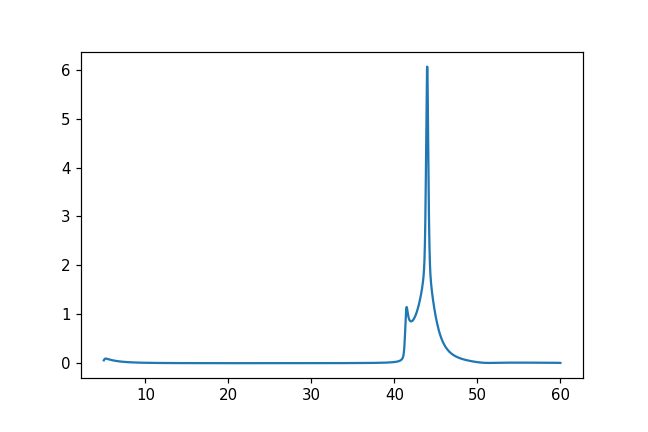

In [3]:
#
# Plot the sample DIFFaX output, as a sanity check.
#
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
pred = np.array(rv['spc'],dtype=np.float64)
plt.plot(pred[:,0],pred[:,2])

In [4]:
xd = pred[:,0]
yd = pred[:,2]

In [5]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy as np
def opt_f(x,osf,tp):
    thmin = np.amin(x)
    thmax = np.amax(x)
    thstep = np.amin(np.diff(x))
    finp = """INSTRUMENTAL
X-RAY
1.5418
PSEUDO-VOIGT .89 -.32 .08 .6 trim
STRUCTURAL
2.52 2.52 2.06 120
6/MMM
2
LAYER 1
CENTROSYMMETRIC
C   1 -1/3 -1/6 -1/8 1 1
LAYER 2
CENTROSYMMETRIC
C   1 1/3 1/6 -1/8 1 1
STACKING
recursive
infinite
TRANSITIONS
{tp} 2/3 1/3 1
{tpinv} 0 0 1
{tpinv} 0 0 1
{tp} -2/3 -1/3 1
""".format(tp=tp,tpinv=1.0-tp)
    rv = runDIFFaXExt(finp,thmin=thmin,thmax=thmax,thstep=thstep)
    irv = np.array(rv['spc'],dtype=np.float64)
    irv = interp1d(irv[:,0],irv[:,2])
    return osf*irv(x)
#newrv = opt_f(xd,1.0,0.9)
rv = curve_fit(opt_f,xd,yd,p0=[0.95,0.9],bounds=((0.0,0.0),(np.inf,1.0)),xtol=0.01,diff_step=1e-6,verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1031e+02                                    3.47e+03    
       1              2         4.2106e+01      1.68e+02       1.03e-01       7.44e+02    
       2              3         1.0735e+01      3.14e+01       7.27e-02       2.17e+02    
       3              4         1.7492e+00      8.99e+00       7.46e-02       8.44e+01    
       4              5         4.0383e-01      1.35e+00       2.67e-02       4.23e+01    
       5              6         1.0574e-01      2.98e-01       1.00e-02       2.08e+01    
`xtol` termination condition is satisfied.
Function evaluations 6, initial cost 2.1031e+02, final cost 1.0574e-01, first-order optimality 2.08e+01.


In [6]:
print(rv)

(array([0.99240596, 0.70739892]), array([[ 2.92097976e-08, -5.51718337e-09],
       [-5.51718337e-09,  4.94942562e-09]]))


<IPython.core.display.Javascript object>


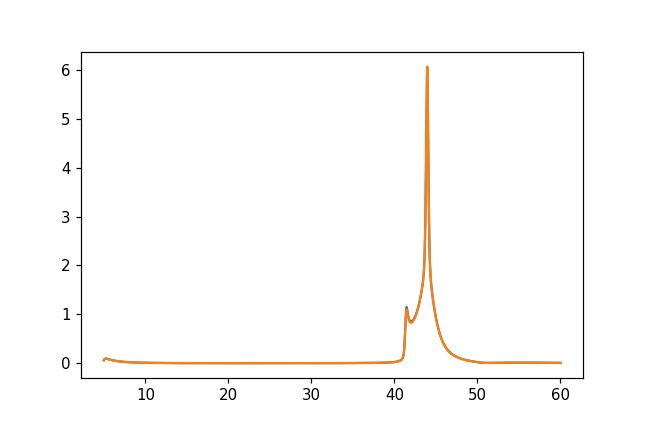

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
newrv = opt_f(xd,*rv[0])
plt.plot(xd,yd)
plt.plot(xd,newrv)

In [8]:
#
# This function constructs and executes a DIFFaX run for
# a given crystallographic input and ancillary parameters.
# For compatibility with a range of actual python structure
# implementations, expects inputs in a semi-processed form.
# Parameters:
# a,b,c = lattice parameters in angstroms, with "c" being the stacking axis
#         (perpendicular to a and b).
# gamma = angle between a and b.
# layers = list, containing atom info for each layer
# trans[i][j] = list of lists specifying the
#               transition probability and vector
#               for each i-j pair as a 4-tuple (prob,dx,dy,dz)
#               prob as a fraction, dx,dy,dz as fractions of a,b,c
# Each individual layer in layers is a list of tuples, containing:
#  (sym, x, y, z, Biso, occ)
# where sym is the atomic symbol, x,y,z are fractional coordinates, Biso
# is the thermal parameter, and occ is the occupancy. No symmetry is
# assumed in any layer, so *all* atoms must be included.
# If it is *not* the first layer, than this can also specify the index
# of the equivalent layer. That means:
#   layers[0] = [...]
#   layers[1] = 0
# would define layer 2 (=1) as the same as layer 1 (=0)
# Optional parameters:
# lam = wavelength in angstrom
# gu, gv, gw = gaussian u, v, w values
# **kwargs = extra arguments to pass to runDIFFaXExt
#
def runDIFFaX(a, b, c, gamma, layers, trans, lam=1.5418, gu=0.1, gv=-0.036, gw=0.009, **kwargs):
    abcga = "{a:.6f} {b:.6f} {c:.6f} {g:.3f}".format(a=a,b=b,c=c,g=gamma)
    inpdat = """INSTRUMENTAL
X-RAY
{lam:.6f}
GAUSSIAN {gu:.5f} {gv:.5f} {gw:.5f}
STRUCTURAL
{abcga}
UNKNOWN
{nl}""".format(lam=lam,gu=gu,gv=gv,gw=gw,abcga=abcga,nl=len(layers))
    l = 1
    for layer in layers:
        if isinstance(layer,int):
            inpdat += "\nLAYER {lnum} = 1".format(lnum=l)
        else:
            inpdat += "\nLAYER {lnum}\nNONE".format(lnum=l)
            n = 1
            for r in layer:
                inpdat += "\n{sym:4s} {n} {x:.6f} {y:.6f} {z:.6f} {Biso:.3f} {occ:.4f}".format(sym=r[0],n=n,x=r[1],y=r[2],z=r[3],Biso=r[4],occ=r[5])
                n += 1
        l += 1
    inpdat += """\nSTACKING
recursive
infinite
TRANSITIONS"""
    for i in range(0,len(trans)):
        for j in range(0,len(trans[i])):
            inpdat += "\n{prob} {dx:.6f} {dy:.6f} {dz:.6f}".format(prob=trans[i][j][0],dx=trans[i][j][1],dy=trans[i][j][2],dz=trans[i][j][3])
    return runDIFFaXExt(inpdat, **kwargs)

In [9]:
#
# Sample approach to read a CIF using the Atomic Simulation Environment
# and then compute the diffraction pattern using DIFFaX with two
# identical layers and random porbability of transitioning between
# them (this corresponds to no stacking faults, just for illustration)
#
import ase.io
nb3cl8 = ase.io.read('Nb3Cl8_300K.cif')
abcalbega = nb3cl8.get_cell_lengths_and_angles()
layer1 = []
for sym,xyz in zip(nb3cl8.get_chemical_symbols(),nb3cl8.get_scaled_positions()):
    layer1.append((sym,xyz[0],xyz[1],xyz[2],1.0,1.0))
layers = [layer1, 0]
trans = [[(0.5,0,0,1),(0.5,0,0,1)],[(0.5,0,0,1),(0.5,0,0,1)]]
rv = runDIFFaX(abcalbega[0],abcalbega[1],abcalbega[2],abcalbega[5],layers,trans,thmin=4,thmax=70,thstep=0.02)
for r in rv['stdout'].splitlines():
    print(r)

/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(164, setting=1). This may result in wrong setting!
  setting_name, spacegroup))


b' ***************************************************'
b' ***************************************************'
b' *                                                 *'
b' *  DDDD     II   FFFFFF   FFFFFF           X   X  *'
b' *  D   D    II   F        F        aaaa     X X   *'
b' *  D    D   II   FFFF     FFFF    a    a     X    *'
b' *  D   D    II   F        F       a   aa    X X   *'
b' *  DDDD     II   F        F        aaa a   X   X  *'
b' *                                                 *'
b' ***************************************************'
b' ****************** DIFFaX v1.813 ******************'
b' ***************************************************'
b' ***************** 19th May,  2010 *****************'
b' ***************************************************'
b' *                                                 *'
b' *   A computer program for calculating            *'
b' *   Diffraction Intensity From Faulted Crystals   *'
b' *                                            

In [10]:
def get_layers(tp,dnbx,dnby,dnbz):
    layer1 = []
    for sym,xyz in zip(nb3cl8.get_chemical_symbols(),nb3cl8.get_scaled_positions()):
        if sym == 'Nb':
            layer1.append((sym,xyz[0]+dnbx,xyz[1]+dnby,xyz[2]+dnbz,1.0,1.0))
        else:
            layer1.append((sym,xyz[0],xyz[1],xyz[2],1.0,1.0))
    return [layer1, 0]

def get_trans(tp,*args):
    return [[(tp,0.6666666666667,0.3333333333,1),(1-tp,0,0,1)],[(1-tp,0,0,1),(tp,0.6666666666667,0.3333333333,1)]]

abcga = [abcalbega[0],abcalbega[1],abcalbega[2],abcalbega[5]]

def opt_f(abcga,get_layers,get_trans,x,osf,*args):
    thmin = np.amin(x)
    thmax = np.amax(x)
    thstep = np.amin(np.diff(x))
    layers = get_layers(*args)
    trans = get_trans(*args)
    rv = runDIFFaX(*abcga,layers,trans,thmin=thmin,thmax=thmax,thstep=thstep)
    irv = np.array(rv['spc'],dtype=np.float64)
    irv = interp1d(irv[:,0],irv[:,2])
    return osf*irv(x)


<IPython.core.display.Javascript object>


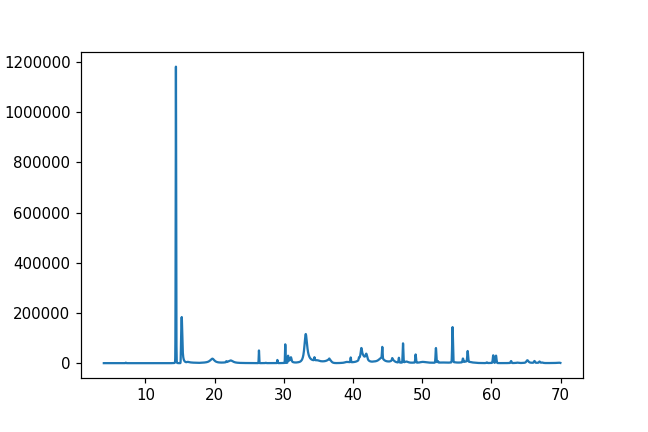

In [11]:
import csv
with open('Nb3Cl8-Faulted.csv', 'r', newline='') as file:
    reader = csv.reader(file,delimiter=',')
    arr = []
    for x,y in reader:
        arr.append([x,y])
arr = np.array(arr,dtype=np.float64)
xd = arr[:,0]
yd = arr[:,1]
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(xd,yd)

In [12]:
rv = curve_fit(lambda x,osf,tp,dnbx,dnby,dnbz: opt_f(abcga,get_layers,get_trans,x,osf,tp,dnbx,dnby,dnbz),xd,yd,p0=[1.0,0.9,0.001,0.001,0.001],bounds=((0.0,0.0,-0.5,-0.5,-0.5),(np.inf,1.0,0.5,0.5,0.5)),xtol=0.003,diff_step=1e-6,verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.2814e+11                                    7.62e+12    
       1              2         6.0869e+11      1.19e+11       2.41e-01       9.11e+12    
       2              3         1.2302e+11      4.86e+11       5.44e-02       1.91e+12    
       3              4         2.3821e+10      9.92e+10       7.16e-02       3.72e+11    
       4              5         3.3341e+09      2.05e+10       4.38e-02       1.08e+11    
       5              6         8.8291e+08      2.45e+09       2.27e-02       4.69e+10    
       6              7         2.3686e+08      6.46e+08       1.19e-02       2.13e+10    
       7              8         4.5896e+07      1.91e+08       6.56e-03       8.49e+09    
       8              9         1.0113e+07      3.58e+07       3.35e-03       3.64e+09    
       9             10         3.6814e+06      6.43e+06       1.08e-03       1.73e+09    

<IPython.core.display.Javascript object>


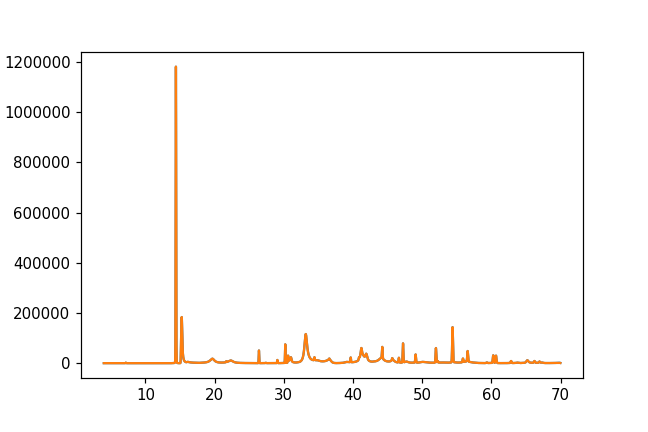

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
newrv = opt_f(abcga,get_layers,get_trans,xd,*rv[0])
plt.plot(xd,yd)
plt.plot(xd,newrv)

In [14]:
print(rv)

(array([0.78003518, 0.70037629, 0.02274676, 0.01918963, 0.01000838]), array([[ 2.70089044e-10, -1.38246038e-11,  1.67172157e-11,
         1.43549968e-11,  2.31811924e-12],
       [-1.38246038e-11,  2.04962668e-10, -2.58057999e-12,
        -4.61864986e-12, -1.07624835e-12],
       [ 1.67172157e-11, -2.58057999e-12,  2.36091555e-09,
        -2.82848714e-09, -2.54961287e-11],
       [ 1.43549968e-11, -4.61864986e-12, -2.82848714e-09,
         4.98087427e-09, -2.30105287e-11],
       [ 2.31811924e-12, -1.07624835e-12, -2.54961287e-11,
        -2.30105287e-11,  1.06663260e-10]]))


In [15]:
import ase.build
nb3cl8slab = ase.build.cut(nb3cl8,c=(0,0,0.5))
nb3cl8slab2 = ase.build.cut(nb3cl8,c=(0,0,0.5),origo=(0,0,0.5))

In [16]:
from ase_notebook import AseView, ViewConfig
config = ViewConfig()
ase_view = AseView(config)
ase_view.config.atom_show_label = True
ase_view.config.canvas_background_opacity = 0.0
ase_view.config.rotations = "45x,45y,45z"
svg = ase_view.make_render(ase.build.stack(nb3cl8slab,nb3cl8slab2), center_in_uc=True)
svg

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 113.58394403234087), …